In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Import all curve reparametrization functions
from deepshape.curves import *

# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# Analytic diffeomorphism
g = LogStepDiff()

# Define Curves 
c1 = Infinity()  # See deepshape.curves.curves for definition.
c2 = c1.compose(g)

# c1 = Circle()
# c2 = HalfCircle()

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
q, r = Qmap(c2), Qmap(c1)
# q, r = SRVT(c2), SRVT(c1)

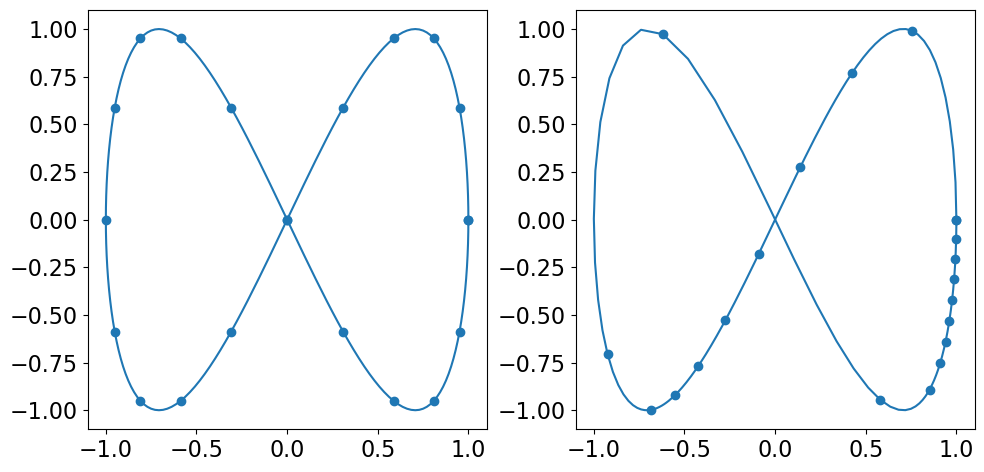

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_curve(c1, dotpoints=21, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.tight_layout()
plt.show()

[Iter     1] loss: 9.441216
[Iter     2] loss: 8.478292
[Iter     3] loss: 6.909301
[Iter     4] loss: 6.759073
[Iter     5] loss: 5.688523
[Iter     6] loss: 2.033624
[Iter     7] loss: 1.281039
[Iter     8] loss: 1.115911
[Iter     9] loss: 0.414872
[Iter    10] loss: 0.281810
[Iter    11] loss: 0.218611
[Iter    12] loss: 0.191069
[Iter    13] loss: 0.177779
[Iter    14] loss: 0.144955
[Iter    15] loss: 0.123800
[Iter    16] loss: 0.076931
[Iter    17] loss: 0.016401
[Iter    18] loss: 0.015529
[Iter    19] loss: 0.012453
[Iter    20] loss: 0.011210
[Iter    21] loss: 0.010076
[Iter    22] loss: 0.008518
[Iter    23] loss: 0.008365
[Iter    24] loss: 0.008120
[Iter    25] loss: 0.007597
[Iter    26] loss: 0.007094
[Iter    27] loss: 0.006441
[Iter    28] loss: 0.005785
[Iter    29] loss: 0.005162
[Iter    30] loss: 0.004762
[Iter    31] loss: 0.003927
[Iter    32] loss: 0.003035
[Iter    33] loss: 0.002937
[Iter    34] loss: 0.002879
[Iter    35] loss: 0.002741
[Iter    36] loss: 0

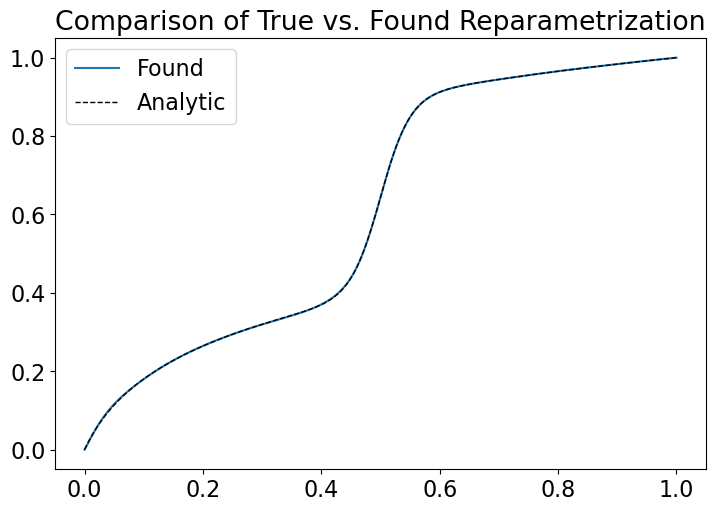

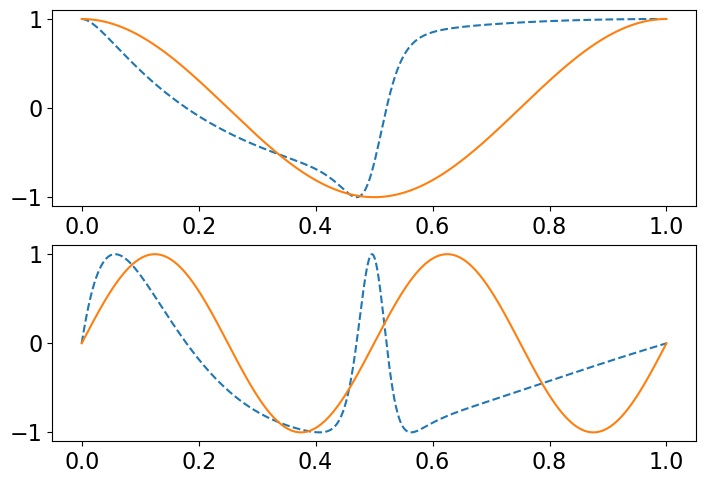

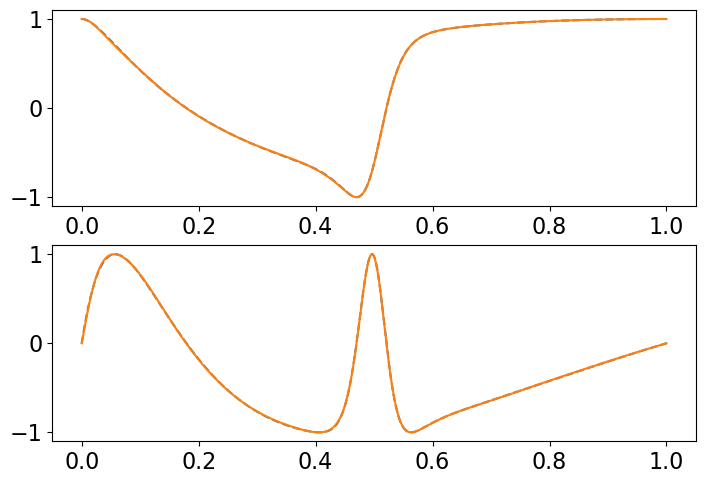

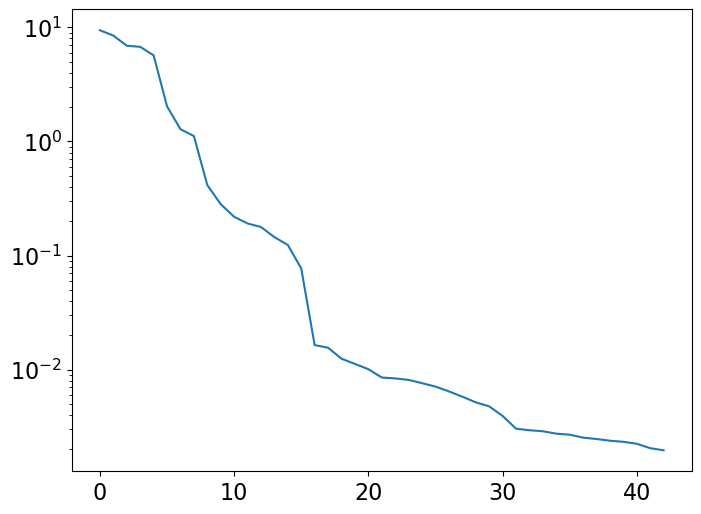

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
# Create reparametrization network
RN = CurveReparametrizer([
    SineSeries(10) for i in range(5)
])

# Define loss function
loss_func = CurveDistance(q, r, k=1024)


# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=1e-2, max_iter=100, line_search_fn='strong_wolfe')
scheduler = None


# optimizer = optim.Adam(RN.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10, threshold=0.,
#     threshold_mode='rel', cooldown=1, min_lr=1e-6, eps=1e-08,
#     verbose=True)


# Train with BFGS-optimizer
error = reparametrize(RN, loss_func, optimizer, 200, Logger(1), scheduler=scheduler)


x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

plt.figure()
plt.semilogy(error)
plt.show()

__Repeated using GPU (if available) for a large network takes more time, but allows very small errors.__

[Iter     1] loss: 9.442791
[Iter     6] loss: 1.249095
[Iter    11] loss: 0.233906
[Iter    16] loss: 0.021704
[Iter    21] loss: 0.000591
[Iter    26] loss: 0.000023
[Iter    31] loss: 0.000006
[Iter    36] loss: 0.000003
[Iter    41] loss: 0.000002
[Iter    46] loss: 0.000002

Finished training in 9.34858s


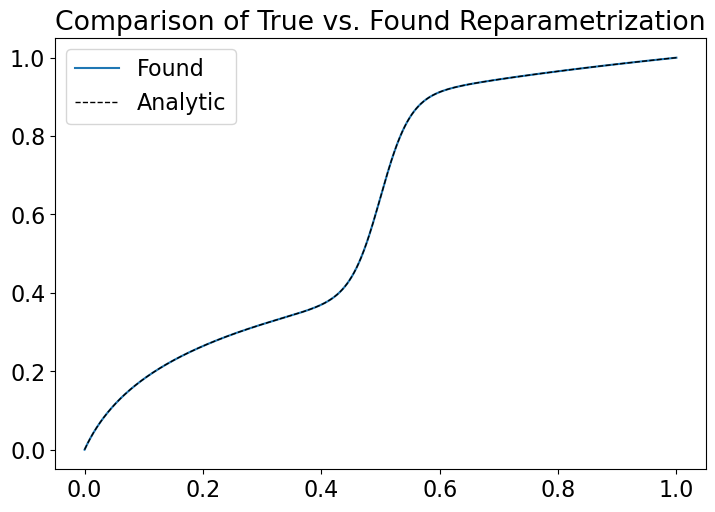

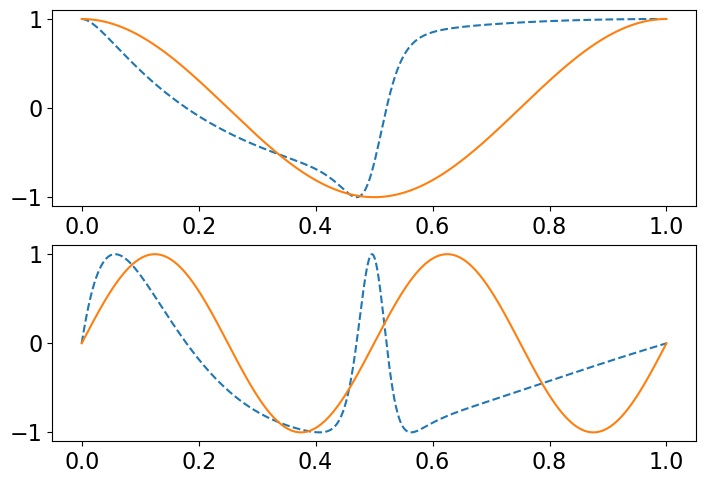

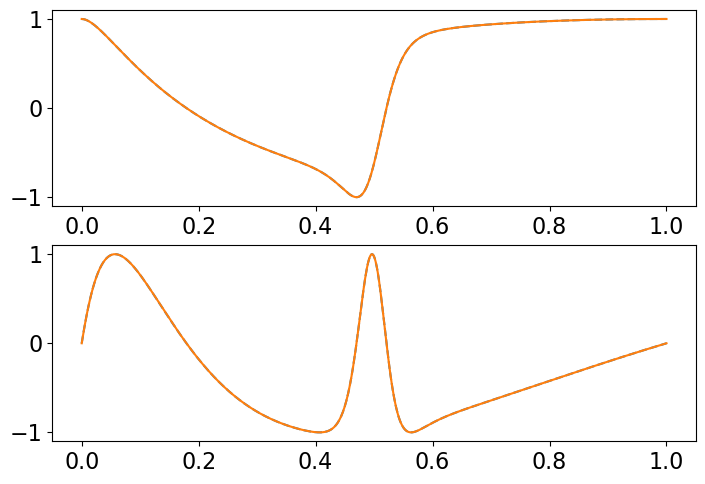

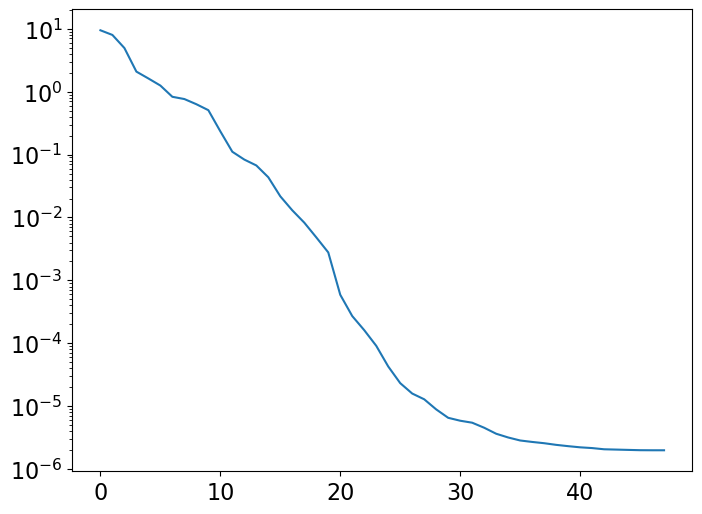

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create reparametrization network
RN = CurveReparametrizer([
    SineSeries(100) for _ in range(100)
]).to(device)

# Define loss function
loss_func = CurveDistance(q, r, k=2048).to(device)

# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=1.0, max_iter=200, line_search_fn='strong_wolfe')
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# Train with BFGS-optimizer
error = reparametrize(RN, loss_func, optimizer, 100, Logger(5))#, scheduler=scheduler)

RN.to("cpu")
loss_func.to("cpu")

x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

plt.figure()
plt.semilogy(error)
plt.show()